
#### OBJETIVO: Generacion de mapas anuales a partir de los datos diarios

In [7]:
import numpy as np
import rasterio
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

print("Libreria ok")

Libreria ok


In [2]:

# -----------------------------
# Parámetros
# -----------------------------
year = 2024
modelo = "01-RF-CV-M1-170625-CH"
estacion = "CH"

ruta_diarios = (
    f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/salidas/"
    f"SalidasDiarias/{modelo}/{year}"
)

ruta_salida = (
    f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/Salidas/"
    f"SalidasAnuales/{modelo}"
)

Path(ruta_salida).mkdir(parents=True, exist_ok=True)

# -----------------------------
# Listar rasters diarios
# -----------------------------
lista_rasters = sorted(glob.glob(ruta_diarios + "/*.tif"))
n_files = len(lista_rasters)

print(f"Año {year} - archivos encontrados: {n_files}")

if n_files == 0:
    raise ValueError("⚠️ No se encontraron rasters diarios")

# -----------------------------
# Leer y apilar
# -----------------------------
stack = []

for path in lista_rasters:
    with rasterio.open(path) as src:
        data = src.read(1)
        profile = src.profile

        nodata = src.nodata
        if nodata is not None:
            data = np.where(data == nodata, np.nan, data)

        stack.append(data)

stack = np.stack(stack, axis=0)  # (n_dias, rows, cols)

# -----------------------------
# Promedio anual
# -----------------------------
promedio_anual = np.nanmean(stack, axis=0)

# -----------------------------
# Guardar raster anual
# -----------------------------
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress="lzw",
    nodata=np.nan
)

nombre_salida = (
    f"{ruta_salida}/Promedio_anual_{year}-{modelo}.tif"
)

# with rasterio.open(nombre_salida, "w", **profile) as dst:
#     dst.write(promedio_anual.astype(np.float32), 1)

print("✔ Guardado:", nombre_salida)


Año 2024 - archivos encontrados: 264
✔ Guardado: D:/Josefina/Proyectos/ProyectoChile/CH/modelos/Salidas/SalidasAnuales/01-RF-CV-M1-170625-CH/Promedio_anual_2024-01-RF-CV-M1-170625-CH.tif


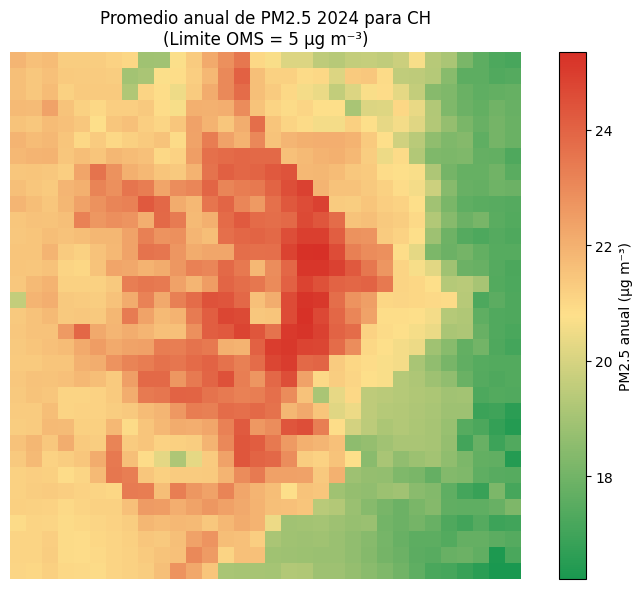

In [15]:
#Hacer mapa

# Colormap verde → amarillo → rojo
# cmap = LinearSegmentedColormap.from_list(
#     "green_yellow_red",
#     ["#2ca25f", "#ffffbf", "#d7191c"]
# )

# cmap = LinearSegmentedColormap.from_list(
#     "green_orange_red",
#     ["#a1d99b", "#fdae61", "#d73027"]
# )
#Setear los colores de interes
cmap = LinearSegmentedColormap.from_list(
    "traffic_light",
    ["#1a9850", "#fee08b", "#d73027"]
)

######
#Plot
plt.figure(figsize=(8, 6))

im = plt.imshow(
    promedio_anual,
    cmap=cmap,
    origin="lower"
)

# im = plt.imshow(
#     promedio_anual,
#     cmap=cmap,
#     origin="lower",
#     vmin=0,
#     vmax=35   # o 50 según tus datos
# )


# Contorno OMS 5 µg/m3
plt.contour(
    promedio_anual,
    levels=[5],
    colors="black",
    linewidths=1.5
)

#Barra
cbar = plt.colorbar(im)
cbar.set_label("PM2.5 anual (µg m⁻³)")

plt.title(f"Promedio anual de PM2.5 {year} para {estacion}\n(Limite OMS = 5 µg m⁻³)")
plt.axis("off")

plt.tight_layout()
plt.show()
